In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

# Load data

## Load subsampled dataset

In [2]:
# Load simulation data
df = pd.read_csv("combined_actin_compression_dataset_all_velocities_and_repeats_subsampled.csv")

## Process dataset

In [3]:
# Apply relevant scaling to cytosim 
# TODO: scale times?
df_cytosim = df[df["simulator"] == "cytosim"].copy()
df_cytosim["xpos"] = df_cytosim["xpos"] * 1000
df_cytosim["ypos"] = df_cytosim["ypos"] * 1000
df_cytosim["zpos"] = df_cytosim["zpos"] * 1000

# Apply relevant scaling to readdy
df_readdy = df[df["simulator"] == "readdy"].copy()

# Combine scaled dataframes
df_rescaled = pd.concat([df_cytosim, df_readdy])

In [4]:
def align_fiber(coords):
    """
    Aligns an array of x, y, z positions along the positive x axis
    """

    # Identify rotation angle based on distance to point furthest from (0,0)
    distances = np.sqrt(np.sum(coords[:,1:] ** 2, axis=1))  
    max_index = np.argmax(distances)
    angle = np.arctan2(coords[max_index, 2], coords[max_index, 1])

    # Create rotation matrix
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, -s), (s, c)))

    # Rotate y and z
    rotated = np.dot(coords[:,1:], R)

    return np.concatenate((coords[:,0:1], rotated), axis=1)

## Plot unaligned fibers

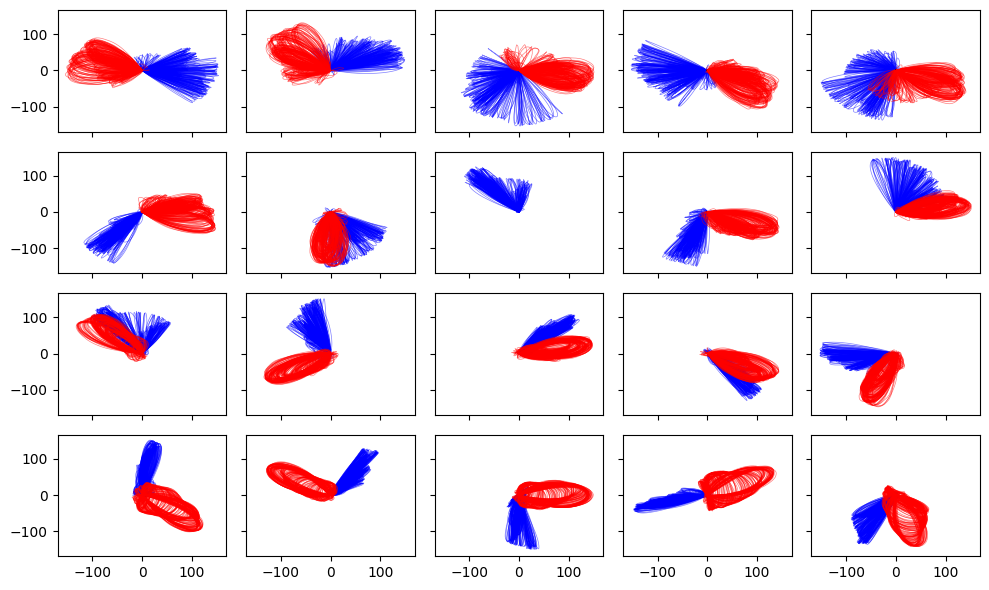

In [5]:
_, ax = plt.subplots(4, 5, figsize=(10,6), sharey=True, sharex=True)
velocities = [4.7, 15, 47, 150]

for (time, velocity, repeat, simulator), group in df_rescaled.groupby(["time", "velocity", "repeat", "simulator"]):
    color = "red" if simulator == "readdy" else "blue"
    row = velocities.index(velocity)
    col = repeat
    
    coords = group[["xpos", "ypos", "zpos"]].values

    ax[row,col].plot(coords[:,1], coords[:,2], lw=0.5, color=color, alpha=0.5)

plt.tight_layout()

## Plot aligned fibers

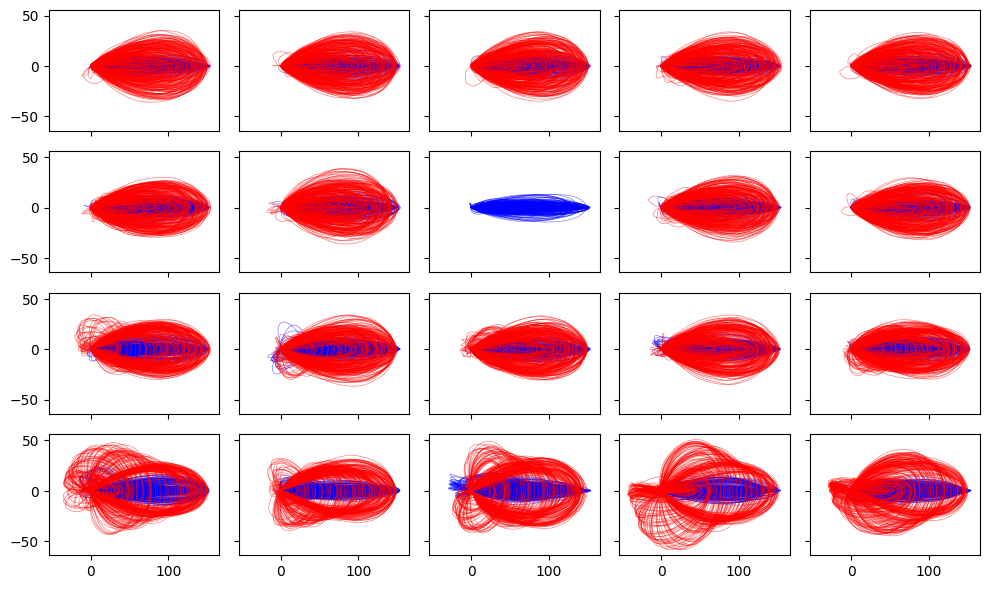

In [7]:
_, ax = plt.subplots(4, 5, figsize=(10,6), sharey=True, sharex=True)
velocities = [4.7, 15, 47, 150]

for (time, velocity, repeat, simulator), group in df_rescaled.groupby(["time", "velocity", "repeat", "simulator"]):
    color = "red" if simulator == "readdy" else "blue"
    row = velocities.index(velocity)
    col = repeat
    
    coords = group[["xpos", "ypos", "zpos"]].values
    if time == 0:
        fiber = coords
    else:
        fiber = align_fiber(coords)
        
    ax[row,col].plot(fiber[:,1], fiber[:,2], lw=0.5, color=color, alpha=0.5)

plt.tight_layout()

# Run PCA

## Align fibers

In [8]:
aligned_fibers = []
fiber_features = []

for (time, velocity, repeat, simulator), group in df_rescaled.groupby(["time", "velocity", "repeat", "simulator"]):
    coords = group[["xpos", "ypos", "zpos"]].values
    
    if time == 0:
        fiber = coords.reshape(-1,1)
    else:
        fiber = align_fiber(coords).reshape(-1,1)
    
    aligned_fibers.append(fiber)
    fiber_features.append({
        "time": time,
        "velocity": velocity,
        "repeat": repeat,
        "simulator": simulator,
    })

aligned_fibers = np.array(aligned_fibers).squeeze()
fiber_features = pd.DataFrame(fiber_features)

## Run PCA

In [9]:
pca = PCA(n_components=2)
pca = pca.fit(aligned_fibers)
transform = pca.transform(aligned_fibers)

## Plot PCs colored by features

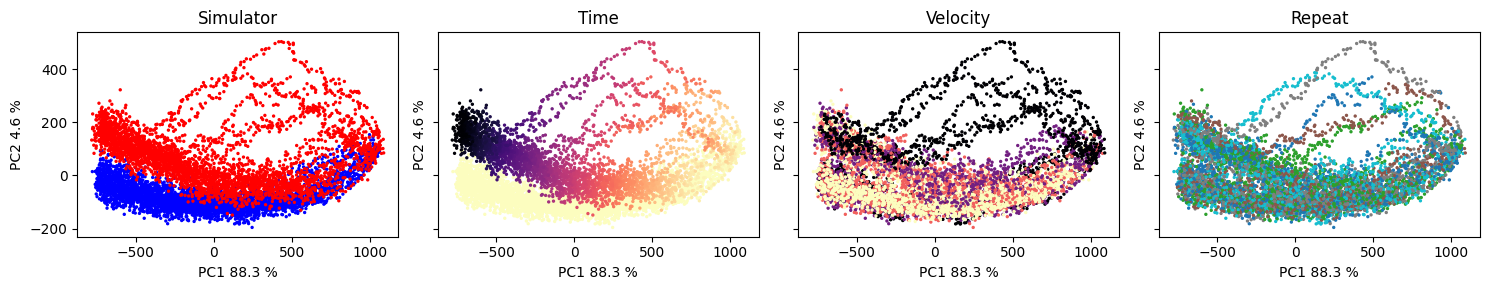

In [27]:
_, ax = plt.subplots(1, 4, figsize=(15,3), sharey=True, sharex=True)

simulator_map = {
    "readdy": "red",
    "cytosim": "blue"
}
velocity_map = {
    4.7: 0,
    15: 1,
    47: 2,
    150: 3,
}

ax[0].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["simulator"].map(simulator_map))
ax[1].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["time"], cmap="magma_r")
ax[2].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["velocity"].map(velocity_map), cmap="magma_r")
ax[3].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["repeat"], cmap="tab10")

features = ["Simulator", "Time", "Velocity", "Repeat"]

for i in range(4):
    ax[i].set_title(features[i])
    ax[i].set_xlabel(f"PC1 {(pca.explained_variance_ratio_[0] * 100):.1f} %")
    ax[i].set_ylabel(f"PC2 {(pca.explained_variance_ratio_[1] * 100):.1f} %")

plt.tight_layout()
plt.show()

## Plot inverse transforms

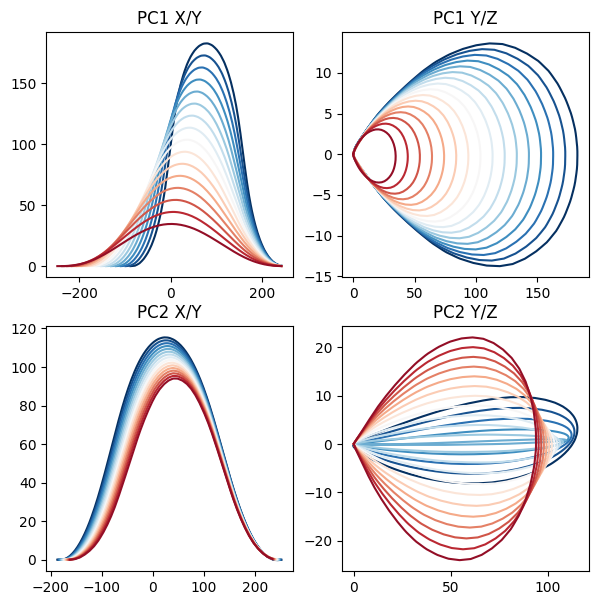

In [26]:
_, ax = plt.subplots(2, 2, figsize=(7,7))

points = np.arange(-2, 2, 0.25)
stdev = transform.std(axis=0)
cmap = plt.colormaps.get_cmap("RdBu_r")

for point in points:
    # Traverse PC 1
    fiber = pca.inverse_transform([point * stdev[0], 0]).reshape(-1,3)
    ax[0,0].plot(fiber[:,0], fiber[:,1], color=cmap((point + 2)/4))
    ax[0,1].plot(fiber[:,1], fiber[:,2], color=cmap((point + 2)/4))

    # Traverse PC 2
    fiber = pca.inverse_transform([0, point * stdev[1]]).reshape(-1,3)
    ax[1,0].plot(fiber[:,0], fiber[:,1], color=cmap((point + 2)/4))
    ax[1,1].plot(fiber[:,1], fiber[:,2], color=cmap((point + 2)/4))

ax[0,0].set_title("PC1 X/Y")
ax[0,1].set_title("PC1 Y/Z")
ax[1,0].set_title("PC2 X/Y")
ax[1,1].set_title("PC2 Y/Z")

plt.tight_layout()
plt.show()